First go at definining the use case.

In [1]:
import pandas as pd
import numpy as np
from cytominer_eval.transform import metric_melt
from pycytominer.cyto_utils import infer_cp_features
import matplotlib.pyplot as plt

In [2]:
# import
df = pd.read_csv('lincs_modz_consensus_data.csv')

In [3]:
# 1. Only keep the dose 6 and dose 0 (DMSO)
df = df.query("Metadata_dose_recode == 0 | Metadata_dose_recode == 6 ")
# 2. Get rid of all compounds that have unknown MOAs
df =  df.query("Metadata_moa != 'unknown'")
# 3. Drop all single Moas
ls = df.Metadata_moa.value_counts() != 1
keys = ls[ls].keys()
df = df[df["Metadata_moa"].isin(keys)].reset_index(drop=True)

In [4]:
def drop_feats(df, threshold):
    features = infer_cp_features(df)
    drop_features = []
    for feat in features:
        if (np.abs(df[feat]) > threshold).any():
            drop_features.append(feat)
    df_out = df.drop(drop_features, axis="columns")
    print("dropped {} features".format(len(drop_features)))
    return df_out
df = drop_feats(df, 30)
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

dropped 54 features


In [5]:
melt = metric_melt(df, features, meta_features, eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
grouped = melt.groupby(['Metadata_broad_sample_pair_a'])

In [6]:
def index_hits(df):
    df.reset_index(drop = True, inplace=True)
    df['rank'] = range(len(df))
    moa = df.Metadata_moa_pair_a.iloc[0]
    df['same_moa'] = df['Metadata_moa_pair_b'] == moa
    df.drop(columns=['pair_a_index', 'pair_b_index', 'similarity_metric'], inplace=True)
    return df

In [7]:
indexes = grouped.apply(lambda x: index_hits(x))

In [8]:
indexes.reset_index(drop=True, inplace=True)
indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'Metadata_moa_pair_a':'target_moa', 'Metadata_moa_pair_b':'match_moa'}, inplace=True)

In [9]:
indexes.head()

,Metadata_Plate_Map_Name_pair_a,Metadata_cell_id_pair_a,target_compound,Metadata_pert_well_pair_a,Metadata_mmoles_per_liter_pair_a,Metadata_dose_recode_pair_a,Metadata_time_point_pair_a,target_moa,Metadata_target_pair_a,Metadata_Plate_Map_Name_pair_b,Metadata_cell_id_pair_b,match_compound,Metadata_pert_well_pair_b,Metadata_mmoles_per_liter_pair_b,Metadata_dose_recode_pair_b,Metadata_time_point_pair_b,match_moa,Metadata_target_pair_b,rank,same_moa
0,C-7161-01-LM6-012,A549,BRD-A00218260-001-03-4,B13,10.0,6,48H,sterol demethylase inhibitor,unknown,C-7161-01-LM6-010,A549,BRD-K13154216-001-01-3,H01,10.0,6,48H,mTOR inhibitor,MTOR,0,False
1,C-7161-01-LM6-012,A549,BRD-A00218260-001-03-4,B13,10.0,6,48H,sterol demethylase inhibitor,unknown,C-7161-01-LM6-009,A549,BRD-K34313798-001-01-6,P07,10.0,6,48H,glutamate receptor antagonist,GRIA1|GRIA2|GRIA3|GRIA4|GRIK1,1,False
2,C-7161-01-LM6-012,A549,BRD-A00218260-001-03-4,B13,10.0,6,48H,sterol demethylase inhibitor,unknown,C-7161-01-LM6-008,A549,BRD-K89402695-001-02-3,P07,10.0,6,48H,thromboxane receptor antagonist,PTGES,2,False
3,C-7161-01-LM6-012,A549,BRD-A00218260-001-03-4,B13,10.0,6,48H,sterol demethylase inhibitor,unknown,C-7161-01-LM6-023,A549,BRD-K67102207-236-07-7,B13,10.0,6,48H,HDAC inhibitor,HDAC1,3,False
4,C-7161-01-LM6-012,A549,BRD-A00218260-001-03-4,B13,10.0,6,48H,sterol demethylase inhibitor,unknown,C-7161-01-LM6-014,A549,BRD-K60341624-001-02-2,G19,10.0,6,48H,glucose dependent insulinotropic receptor agonist,GRPR,4,False


In [10]:
def calc_hits(df, only_first = False):
    group = df.groupby(['target_compound'])
    index_ls = group.apply(lambda x: find_hits(x, only_first = only_first))
    return index_ls

def find_hits(df, only_first):
    #print(df.target_compound.iloc[0])
    index_ls = df[df['same_moa'] == True]['rank'].tolist()
    if len(index_ls) == 0:
            print(df.target_compound.iloc[0])
    if only_first:
        return index_ls[0]
    else:
        return index_ls

In [11]:
index_series = calc_hits(indexes)
index_first_series = calc_hits(indexes, only_first=True)

In [12]:
index_flat = [item for sublist in index_series.tolist() for item in sublist]
index_first_flat = index_first_series.tolist()

In [13]:
# randomized
df_copy = df.copy()
df_copy[features] = df_copy[features].iloc[np.random.permutation(len(df))].reset_index(drop=True)

In [14]:
ran_melt = metric_melt(df_copy, features, meta_features, eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
ran_grouped = ran_melt.groupby(['Metadata_broad_sample_pair_a'])
ran_indexes = ran_grouped.apply(lambda x: index_hits(x))
ran_indexes.reset_index(drop=True, inplace=True)
ran_indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'Metadata_moa_pair_a':'target_moa', 'Metadata_moa_pair_b':'match_moa'}, inplace=True)

In [15]:
ran_index_series = calc_hits(ran_indexes)
ran_index_first_series = calc_hits(ran_indexes, only_first=True)
ran_index_flat = [item for sublist in ran_index_series.tolist() for item in sublist]
ran_index_first_flat = ran_index_first_series.tolist()

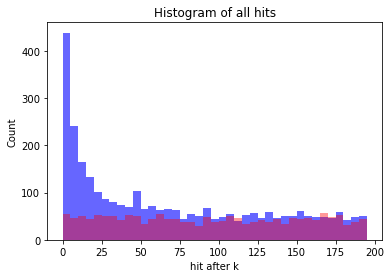

In [18]:
bins = np.arange(0,200,5)
plt.style.use({'figure.facecolor':'white'})
plt.hist(index_flat, bins, alpha=0.6, color='blue')
plt.hist(ran_index_flat, bins,alpha=0.4, color='red')
plt.xlabel('hit after k')
plt.ylabel('Count')
plt.title('Histogram of all hits')
plt.show()

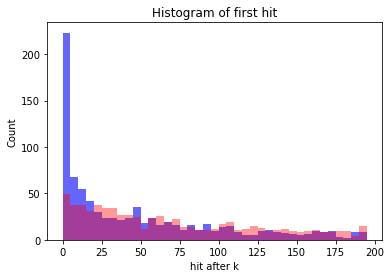

In [19]:
bins = np.arange(0,200,5)
plt.style.use({'figure.facecolor':'white'})
plt.hist(index_first_flat, bins, alpha=0.6, color='blue')
plt.hist(ran_index_first_flat, bins,alpha=0.4, color='red')
plt.xlabel('hit after k')
plt.ylabel('Count')
plt.title('Histogram of first hit')
plt.show()

In [21]:
print(' total hits in top 50:', len([i for i in index_flat if i < 50]))
print(' Random baseline:', len([i for i in ran_index_flat if i < 50]))
print(' first hits in top 50:', len([i for i in index_first_flat if i < 50]))
print(' Random baseline:', len([i for i in ran_index_first_flat if i < 50]))

 total hits in top 50: 1491
 Random baseline: 492
 first hits in top 50: 545
 Random baseline: 340
